<a href="https://colab.research.google.com/github/SabagYoav/Computer-vision/blob/main/Face_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import fetch_lfw_people

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models
from skimage.transform import resize

In [34]:
# Specify the desired minimum number of images per person
min_faces_per_person = 70  # You can adjust this value as needed

# Download the LFW dataset | by setting min_faces.. = 70 i limit the ds to 7 classes
lfw_dataset = fetch_lfw_people(min_faces_per_person=70,color = True)

# Access the dataset components
images = lfw_dataset.images  # Array of face images
target = lfw_dataset.target  # Array of target labels (person identities)
target_names = lfw_dataset.target_names  # Array of target names (person names)

# Print information about the dataset
print("Number of images:", images.shape[0])
print("Number of classes (persons):", target_names.shape[0])
print("Target names:", target_names)

Number of images: 1288
Number of classes (persons): 7
Target names: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


In [36]:
# Resize the images to match the expected input shape of InceptionV3
images_resized = np.array([resize(img, (75, 75)) for img in images])

images_resized_MobileNetV2= np.array([resize(img, (75, 75)) for img in images])
print("images_resized_MobileNetV2 shape: ", images_resized_MobileNetV2[0].shape)#debug line

# Preprocess the resized images
images_preprocessed = np.array([preprocess_input(img) for img in images_resized])

images_resized_MobileNetV2 shape:  (75, 75, 3)


In [37]:
# Load the InceptionV3 model with pre-trained weights (excluding the top layer)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

In [ ]:
from keras.applications import MobileNetV2
from keras.layers import GlobalAveragePooling2D
from keras.models import Model

# Load the MobileNetV2 model with pre-trained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(50, 37, 3))

# Add a global average pooling layer to reduce spatial dimensions
x = GlobalAveragePooling2D()(base_model.output)

# Create the embedding model
embedding_model = Model(inputs=base_model.input, outputs=x)

# Print the summary of the embedding model
embedding_model.summary()


In [39]:
# Function to preprocess and resize face images
def preprocess_image(image):
    # Resize image to 50x37 and preprocess it
    image = tf.image.resize(image, (50, 37))
    image = preprocess_input(image)
    return image

    # Extract features (embeddings) from the images using MobileNetV2
def extract_features(image, label):
    features = base_model.predict(image)
    # Flatten the features to create embeddings
    embeddings = tf.reshape(features, [-1])
    return embeddings, label

In [40]:
images_resized_MobileNetV2= np.array([resize(img, ( 50, 37, 3)) for img in images])
embedings_MobileNetV2 = embedding_model.predict(images_resized_MobileNetV2)

41/41 [==============================] - 5s 79ms/step


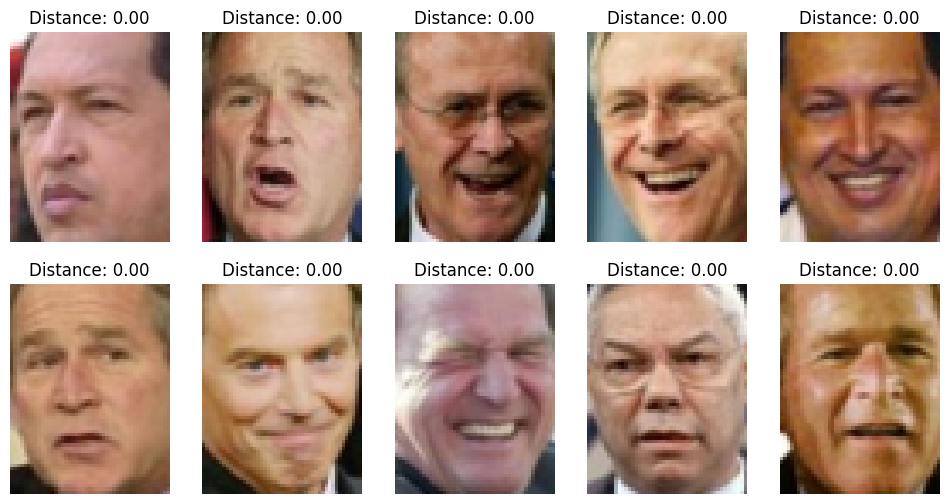

In [41]:
distances = np.linalg.norm(embedings_MobileNetV2 - embedings_MobileNetV2, axis = 1)#Errorrrrrrr this equal 0
colosest_endices = np.argsort(distances)[:10]

plt.figure(figsize=(12, 6))
for i, idx in enumerate(colosest_endices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[idx])  # Assuming images are PIL images or numpy arrays
    plt.axis('off')
    plt.title(f'Distance: {distances[idx]:.2f}')
plt.show()

We can see that the images arent belong to the same class, lets try to devide them into classes using KMeanss

In [10]:
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=200)
kmeans_model.fit(embedings_MobileNetV2)
cluster_labels = kmeans_model.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


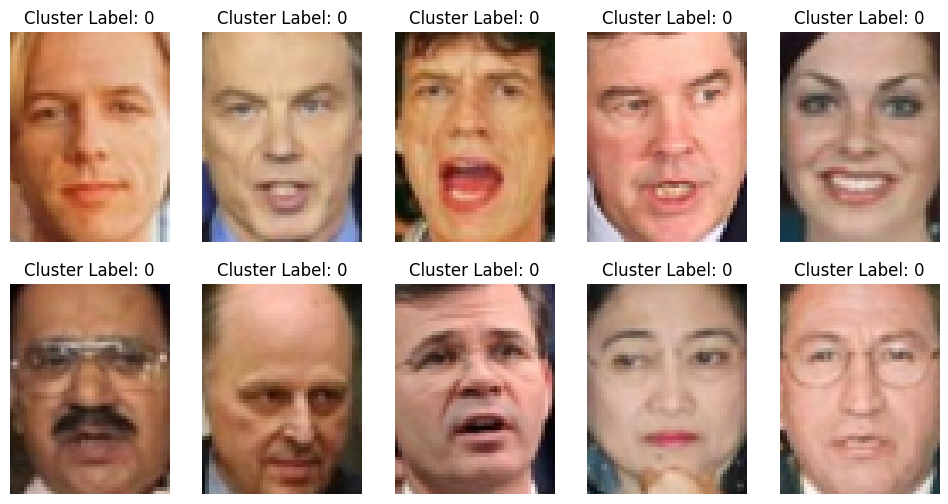

In [11]:
cluster_indices = np.where(cluster_labels == 0)[0]

selected_indices = cluster_indices[:10]

# Show the selected images
plt.figure(figsize=(12, 6))
for i, idx in enumerate(selected_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[idx])  # Assuming images are PIL images or numpy arrays
    plt.axis('off')
    plt.title(f'Cluster Label: {cluster_labels[idx]}')
plt.show()

We can see that the images are NOT from the same class

##Now lets use FaceNet more efficient architeture




In [12]:
%%capture
# Install facenet-pytorch
!pip install /kaggle/input/facenet-pytorch-vggface2/facenet_pytorch-1.0.1-py3-none-any.whl

# Copy model checkpoints to torch cache so they are loaded automatically by the package
!mkdir -p /tmp/.cache/torch/checkpoints/
!cp /kaggle/input/facenet-pytorch-vggface2/20180402-114759-vggface2-logits.pth /tmp/.cache/torch/checkpoints/vggface2_DG3kwML46X.pt
!cp /kaggle/input/facenet-pytorch-vggface2/20180402-114759-vggface2-features.pth /tmp/.cache/torch/checkpoints/vggface2_G5aNV2VSMn.pt

In [ ]:
!pip install facenet_pytorch

In [14]:
# importing libraries
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
import torch
#from torchvision import datasets
from torch.utils.data import DataLoader
from PIL import Image

from sklearn.datasets import fetch_lfw_people

from tqdm import tqdm

In [15]:
# See github.com/timesler/facenet-pytorch:
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')

Running on device: cpu


In [16]:
margin = 80
image_size = 150

# Load face detector
mtcnn = MTCNN(keep_all=False, select_largest=False, post_process=False,
              device=device, min_face_size=100,
              margin=margin, image_size=image_size).eval()

# Load facial recognition model
resnet = InceptionResnetV1(pretrained='vggface2', device=device).eval()

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [17]:
!pip install facenet_pytorch

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')

Running on device: cpu


In [19]:
# Specify the desired minimum number of images per person
min_faces_per_person = 70  # You can adjust this value as needed

# Download the LFW dataset
lfw_dataset = fetch_lfw_people(min_faces_per_person=70,color = True)

# Access the dataset components
images = lfw_dataset.images  # Array of face images
target = lfw_dataset.target  # Array of target labels (person identities)
target_names = lfw_dataset.target_names  # Array of target names (person names)

# Print information about the dataset
print("Number of images:", images.shape[0])
print("Number of classes (persons):", target_names.shape[0])
print("Target names:", target_names)

Number of images: 1288
Number of classes (persons): 7
Target names: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


In [20]:
lfw_dataset.target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

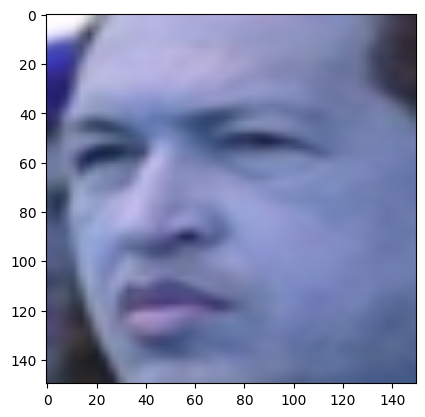

In [21]:
import cv2
img_cv2 = [cv2.cvtColor(img, cv2.COLOR_RGB2BGR)for img in images]
resized_cv2_images = [cv2.resize(img, (150, 150)) for img in img_cv2]
plt.imshow(resized_cv2_images[0])

In [22]:
image_size = 150
margin = 0

mtcnn = MTCNN(keep_all=False, select_largest=False, post_process=False,
              device=device, min_face_size=20,
              margin=margin, image_size=image_size) # initializing mtcnn for face detection

resnet = InceptionResnetV1(pretrained='vggface2', device = device).eval() # initializing resnet for face img to embeding conversion

In [23]:
#dataset=datasets.ImageFolder('photos') # photos folder path
#idx_to_class = {i:c for c,i in dataset.class_to_idx.items()} # accessing names of peoples from folder names

def collate_fn(x):
    return x[0]

loader = DataLoader(resized_cv2_images, collate_fn=collate_fn)

face_list = [] # list of cropped faces from photos folder
name_list = [] # list of names corrospoing to cropped photos
embedding_list = [] # list of embeding matrix after conversion from cropped faces to embedding matrix using resnet

In [24]:
from torchvision.transforms import ToTensor

tf_img = lambda i: ToTensor()(i).unsqueeze(0)
embeddings = lambda input: resnet(input)

In [25]:
list_embs = []
with torch.no_grad():
    for face in tqdm(resized_cv2_images):
        t = tf_img(face).to(device)
        #print("t.shape: ", t.shape)
        e = embeddings(t).squeeze().cpu().tolist()
        list_embs.append(e)

100%|██████████| 1288/1288 [02:16<00:00,  9.43it/s]


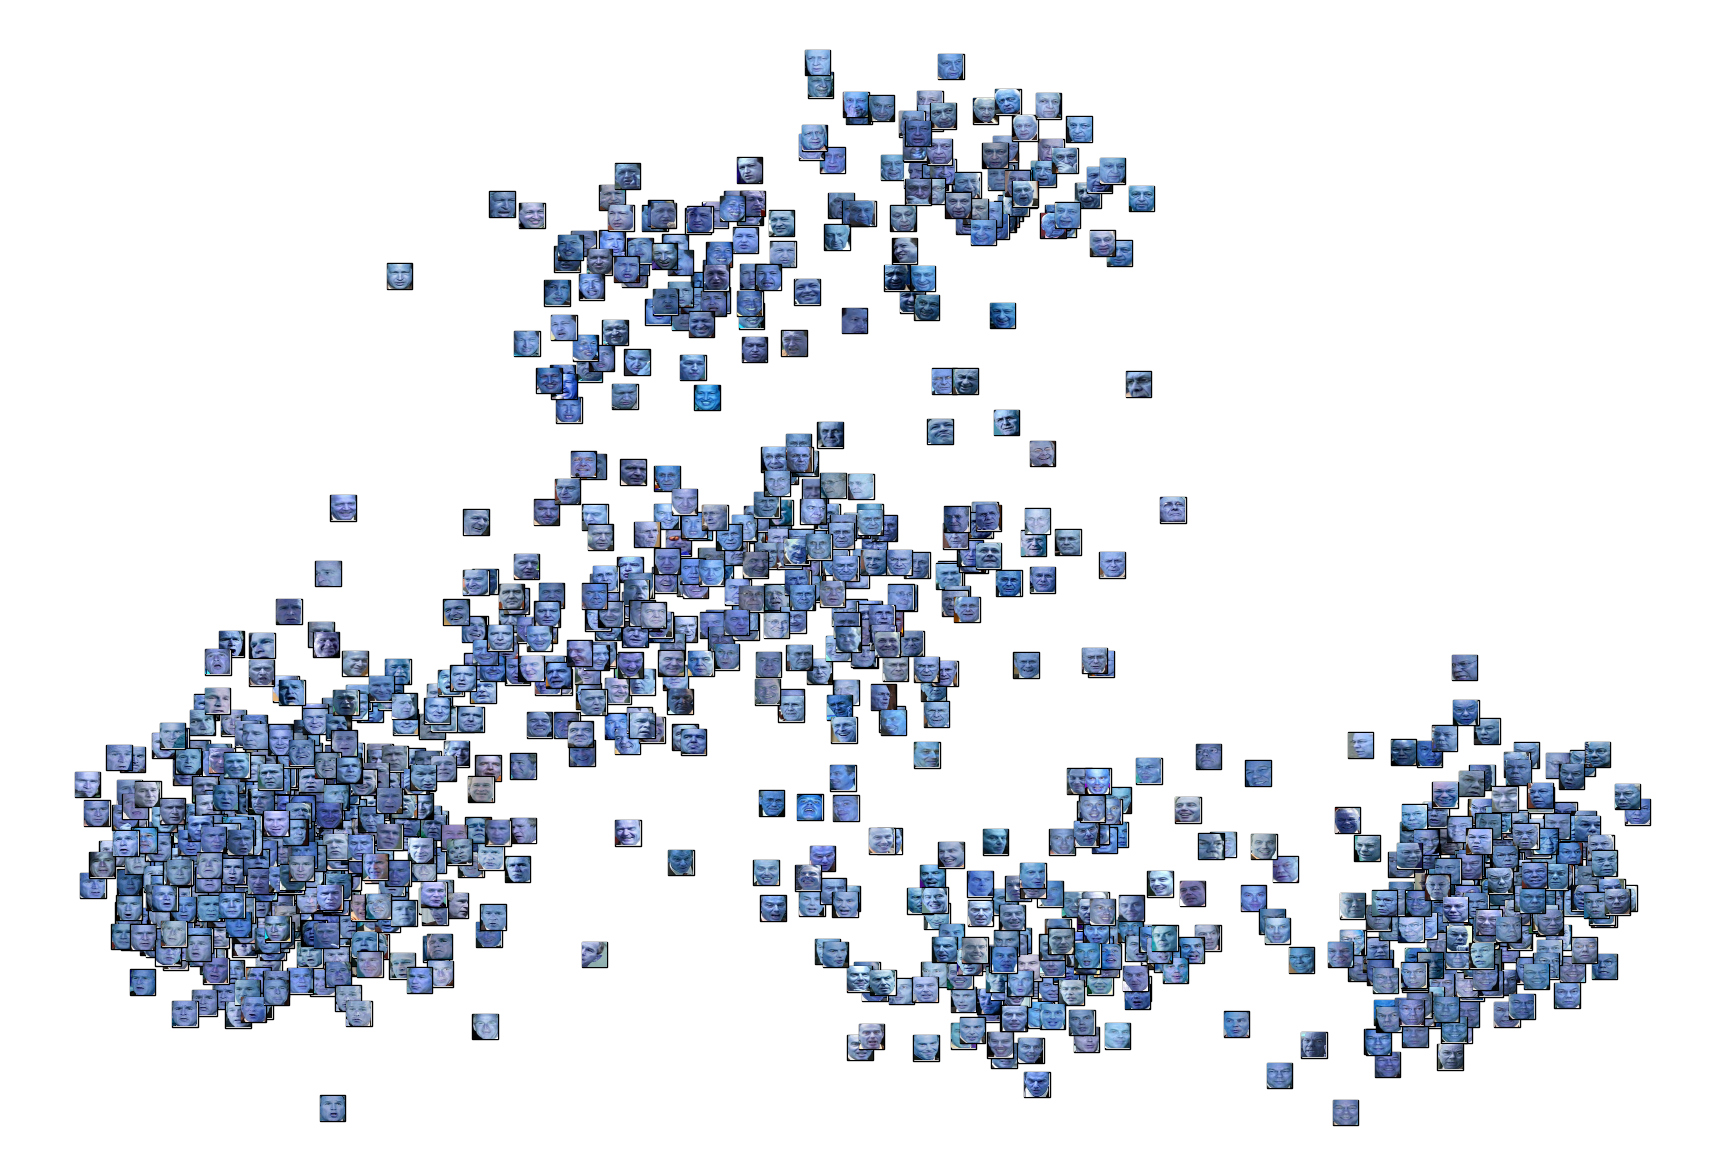

In [26]:
from sklearn.decomposition import PCA
assert len(list_embs) == len(resized_cv2_images)

#dimentionality reduction for ploting the embedding data
x = PCA(n_components=2).fit_transform(list_embs) if len(list_embs[0]) > 2 else list_embs

#exectuting plt.plot of x, 2d pca of embedding vector
f = plt.figure(figsize=(22, 15))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(x[:,0], x[:,1], s=4)
_ = ax.axis('off')
_ = ax.axis('tight')

#plot the faces at the point location at x-pca space
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
zoom=0.12
for i in range(len(resized_cv2_images)):
    image = resized_cv2_images[i]
    im = OffsetImage(image, zoom=zoom)
    bboxprops = dict(edgecolor=None) #if colors is not None else None
    ab = AnnotationBbox(im, x[i], xycoords='data',
                        frameon=(bboxprops is not None),
                        pad=0.02,
                        bboxprops=bboxprops)
    ax.add_artist(ab)

## Clusterring the face embedding vectors using k-means


In [27]:
#imports for kmeans
from sklearn.cluster import KMeans
import numpy as np

#model defenition
kmeans = KMeans(n_clusters=7, random_state=0, n_init="auto").fit(list_embs)
cluster_labels = kmeans.labels_

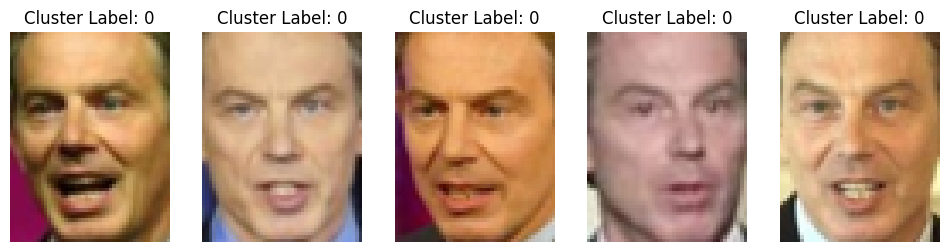

In [33]:
#locating and taking embs associated with cluster 0
cluster_0_indices = np.where(cluster_labels == 0)[0]
cluster_1_indices = np.where(cluster_labels == 1)[0]
cluster_2_indices = np.where(cluster_labels == 2)[0]
cluster_3_indices = np.where(cluster_labels == 3)[0]
cluster_4_indices = np.where(cluster_labels == 4)[0]
cluster_5_indices = np.where(cluster_labels == 5)[0]
cluster_6_indices = np.where(cluster_labels == 6)[0]

selected_indices = cluster_0_indices[:10]

# Show the selected images
plt.figure(figsize=(12, 6))
for i, idx in enumerate(cluster_0_indices[:5]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[idx])  # Assuming images are PIL images or numpy arrays
    plt.axis('off')
    plt.title(f'Cluster Label: {cluster_labels[idx]}')

plt.show()

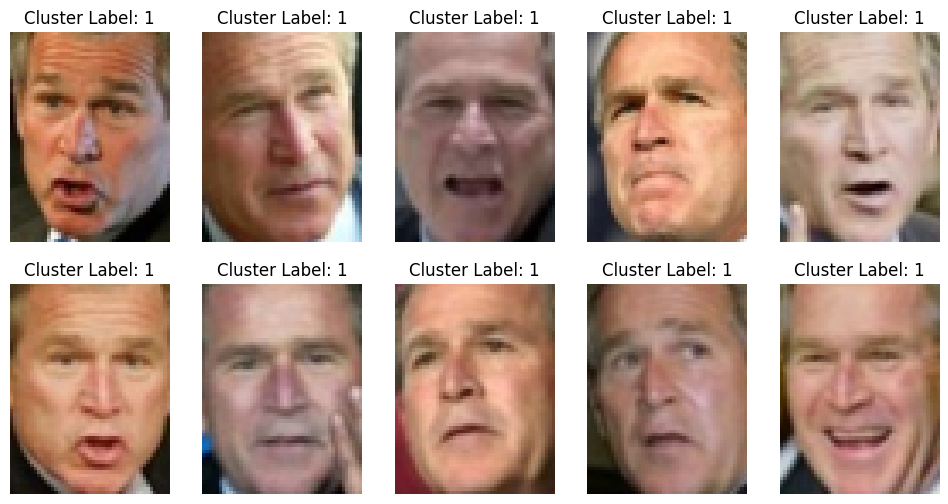

In [29]:
cluster_1_indices = np.where(cluster_labels == 1)[0]

selected_indices = cluster_1_indices[:10]

# Show the selected images
plt.figure(figsize=(12, 6))
for i, idx in enumerate(selected_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[idx])  # Assuming images are PIL images or numpy arrays
    plt.axis('off')
    plt.title(f'Cluster Label: {cluster_labels[idx]}')
plt.show()

### Model evaluation

now lets create a df with cols: embedding, true label, cluster.
so we could check the models performance

In [30]:
def plot_faces(data, n_clusters = 7):
  #dimentionality reduction to 2d for given ds
  reduced_data = PCA(n_components=2).fit_transform(data) if len(data[0]) > 2 else data
  kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4)
  kmeans.fit(reduced_data)

  #exectuting plt.plot of x, 2d pca of embedding vector
  f = plt.figure(figsize=(22, 15))
  ax = plt.subplot(aspect='equal')
  sc = ax.scatter(x[:,0], x[:,1], s=4)
  _ = ax.axis('off')
  _ = ax.axis('tight')

  #plot the faces at the point location at x-pca space
  from matplotlib.offsetbox import OffsetImage, AnnotationBbox
  zoom=0.12
  for i in range(len(resized_cv2_images)):
      image = resized_cv2_images[i]
      im = OffsetImage(image, zoom=zoom)
      bboxprops = dict(edgecolor=None) #if colors is not None else None
      ab = AnnotationBbox(im, x[i], xycoords='data',
                          frameon=(bboxprops is not None),
                          pad=0.02,
                          bboxprops=bboxprops)
      ax.add_artist(ab)

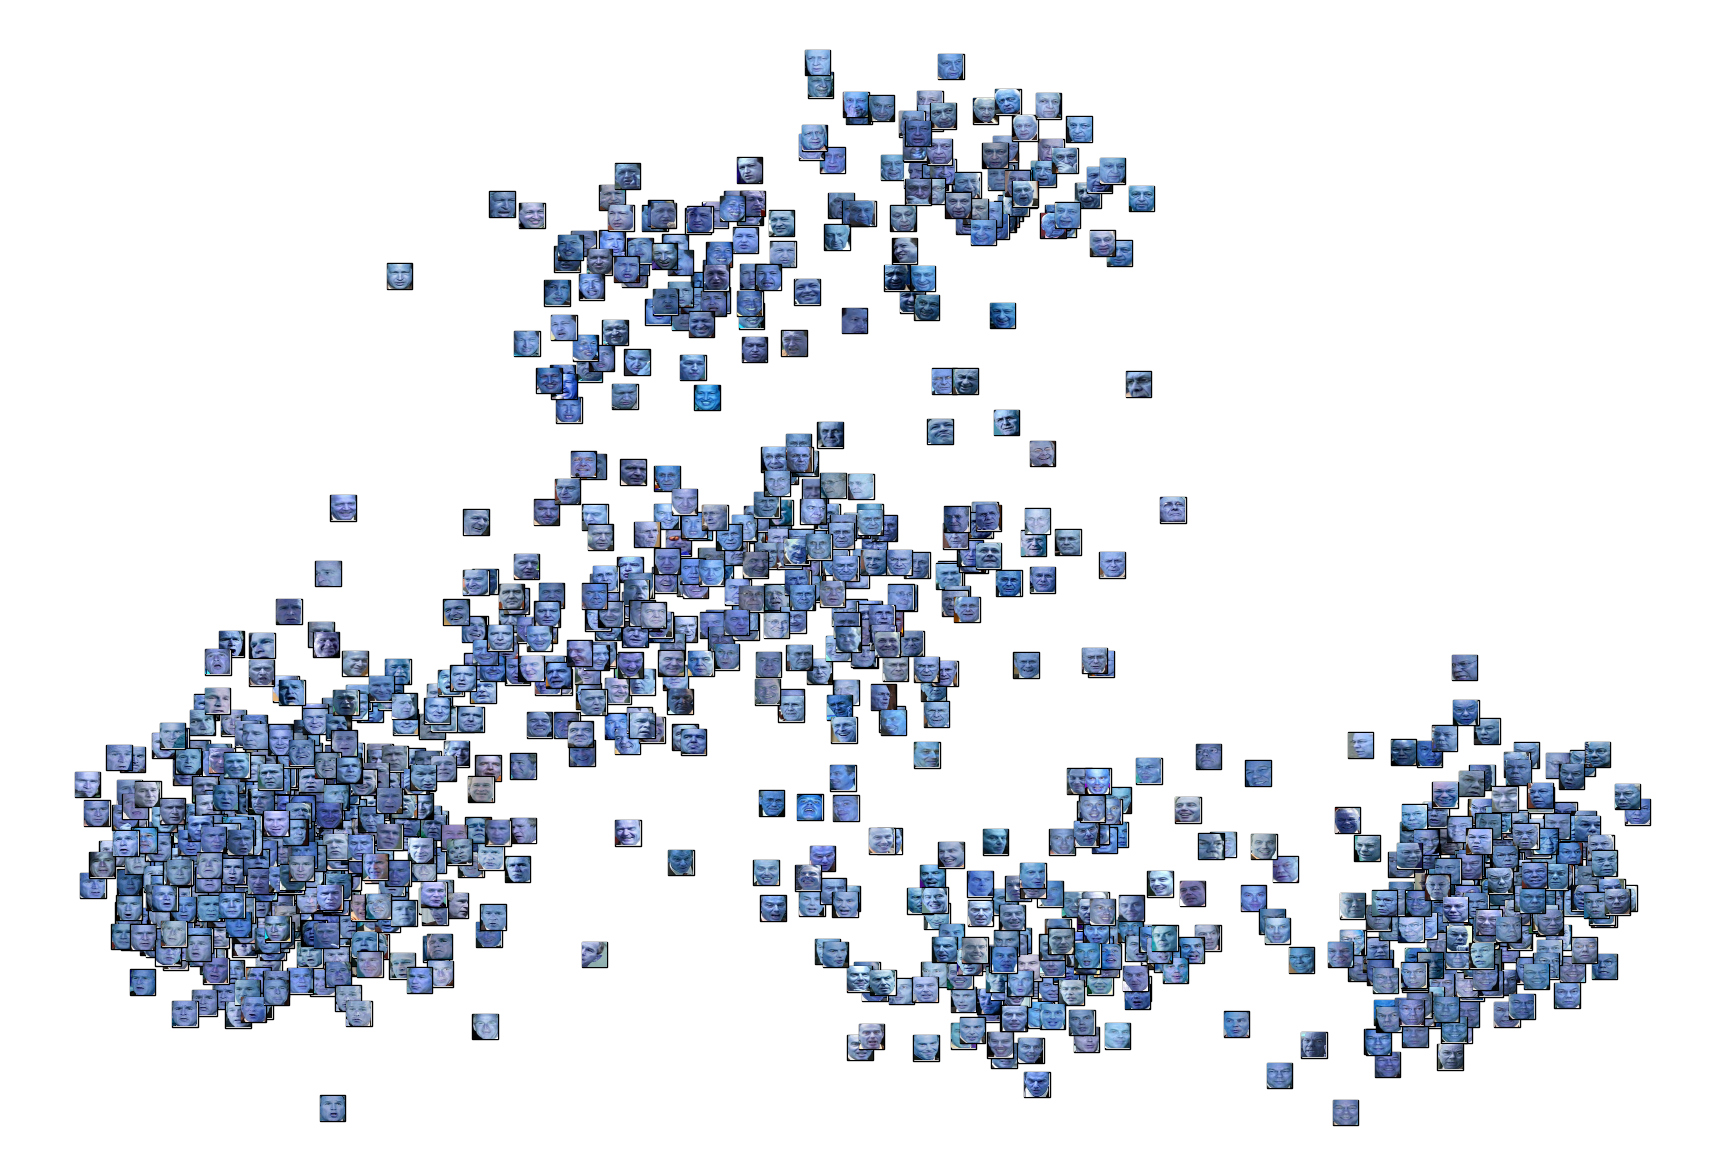

In [31]:
plot_faces(list_embs)